In [1]:
from pathlib import Path
import json

root = Path(r"/Users/jidapachutongchai/Downloads/projectDS/ScopusData")

# collect (year, file_path) for every file in every year folder
all_files = []

for year_dir in sorted(root.iterdir()):
    if year_dir.is_dir():              # 2018, 2019, ...
        year = year_dir.name
        for p in year_dir.iterdir():   # files like 202300001, 201900123, ...
            if p.is_file() and not p.name.startswith("."):
                all_files.append((year, p))

len(all_files), all_files[:5]


FileNotFoundError: [WinError 3] The system cannot find the path specified: '\\Users\\jidapachutongchai\\Downloads\\projectDS\\ScopusData'

In [ ]:
year0, path0 = all_files[0]
print("Year:", year0)
print("Path:", path0)

with open(path0, encoding="utf-8") as f:
    sample = json.load(f)

sample


Year: 2018
Path: /Users/jidapachutongchai/Downloads/projectDS/ScopusData/2018/201800282


{'abstracts-retrieval-response': {'item': {'ait:process-info': {'ait:status': {'@state': 'update',
     '@type': 'core',
     '@stage': 'S300'},
    'ait:date-delivered': {'@day': '23',
     '@timestamp': '2021-02-23T06:09:27.000027-05:00',
     '@year': '2021',
     '@month': '02'},
    'ait:date-sort': {'@day': '15', '@year': '2018', '@month': '11'}},
   'xocs:meta': {'xocs:funding-list': {'@pui-match': 'primary',
     '@has-funding-info': '1',
     'xocs:funding-addon-generated-timestamp': '2018-10-23T21:21:48.112Z',
     'xocs:funding-addon-type': 'http://vtw.elsevier.com/data/voc/AddOnTypes/50.7/car'}},
   'bibrecord': {'head': {'author-group': [{'affiliation': {'country': 'Thailand',
        'address-part': '254 Phayathai Road',
        'postal-code': '10330',
        '@afid': '60028190',
        '@country': 'tha',
        'city': 'Bangkok',
        'organization': [{'$': 'Fuels Research Center'},
         {'$': 'Department of Chemical Technology'},
         {'$': 'Faculty of Sci

In [ ]:
import pandas as pd

def extract_paper_info(data, year, file_id):
    """
    data  = one JSON dict (sample)
    year  = folder year (string like '2018')
    file_id = file name like '201800028'
    """
    info = {
        "year": int(year),
        "file_id": file_id,
        "title": None,
        "abstract": None,
        "keywords": None,
        "citations": None,
        "doi": None,
        "source_title": None
    }

    root = data.get("abstracts-retrieval-response", {})

    # ---- coredata block (usually has title, citations, etc.) ----
    coredata = root.get("coredata", {})

    title = coredata.get("dc:title")
    if isinstance(title, dict):
        # sometimes wrapped like {"$": "..."}
        title = title.get("$")
    info["title"] = title

    # abstract: try several typical places
    abstract = coredata.get("dc:description")
    if isinstance(abstract, dict):
        abstract = abstract.get("$")

    if not abstract:
        # sometimes inside bibrecord/head/abstracts
        try:
            abstract_block = (
                root
                .get("item", {})
                .get("bibrecord", {})
                .get("head", {})
                .get("abstracts", {})
            )
            if isinstance(abstract_block, dict):
                # "abstract" can be list or dict
                abs_obj = abstract_block.get("abstract")
                if isinstance(abs_obj, dict):
                    para = abs_obj.get("ce:para")
                    if isinstance(para, list):
                        abstract = " ".join(str(p) for p in para)
                    else:
                        abstract = str(para)
                elif isinstance(abs_obj, list):
                    paras = []
                    for a in abs_obj:
                        para = a.get("ce:para")
                        if isinstance(para, list):
                            paras.extend(para)
                        elif para:
                            paras.append(para)
                    abstract = " ".join(str(p) for p in paras if p)
        except Exception:
            pass

    info["abstract"] = abstract

    # keywords: often under authkeywords / author-keyword
    kw_list = []
    authk = root.get("authkeywords") or coredata.get("authkeywords")
    if isinstance(authk, dict):
        ak = authk.get("author-keyword")
        if isinstance(ak, list):
            for k in ak:
                if isinstance(k, dict):
                    text = k.get("$") or k.get("ce:text")
                    if text:
                        kw_list.append(str(text))
        elif isinstance(ak, dict):
            text = ak.get("$") or ak.get("ce:text")
            if text:
                kw_list.append(str(text))
    info["keywords"] = "; ".join(kw_list) if kw_list else None

    # citations
    cit = coredata.get("citedby-count")
    if isinstance(cit, dict):
        cit = cit.get("$")
    try:
        info["citations"] = int(cit) if cit is not None else None
    except ValueError:
        info["citations"] = None

    # doi
    doi = coredata.get("prism:doi")
    if isinstance(doi, dict):
        doi = doi.get("$")
    info["doi"] = doi

    # source title (journal / conference)
    src = coredata.get("prism:publicationName") or coredata.get("prism:aggregationType")
    if isinstance(src, dict):
        src = src.get("$")
    info["source_title"] = src

    return info


In [ ]:
rows = []

for year, path in all_files:
    try:
        with open(path, encoding="utf-8") as f:
            data = json.load(f)

        row = extract_paper_info(data, year, path.name)
        rows.append(row)

    except Exception as e:
        print(f"Error in file {path}: {e}")

len(rows)

{'year': 2018,
 'file_id': '201800282',
 'title': 'Recent developments in bifunctional air electrodes for unitized regenerative proton exchange membrane fuel cells – A review',
 'abstract': 'Unitized regenerative proton exchange membrane fuel cell (UR-PEMFC) technology has progressed in the recent past and has started appearing towards few applications. However, the UR-PEMFC viability is limited by its lower round-trip efficiency mainly due to several reasons such as sluggish air electrode reactions, lower performance/stability, higher materials cost etc. In this context, many approaches are being implemented for efficiency enhancement including design and development of effective bifunctional air electrodes (oxygen reduction and evolution reactions) materials both for fuel cell and electrolyzer modes as well as for optimization of operating condition for performance stability in real life applications. This review focusses on the recent developments of air electrode active materials d

In [ ]:
df = pd.DataFrame(rows)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216 entries, 0 to 20215
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          20216 non-null  int64  
 1   file_id       20216 non-null  object 
 2   title         20215 non-null  object 
 3   abstract      19551 non-null  object 
 4   keywords      16454 non-null  object 
 5   citations     20212 non-null  float64
 6   doi           19035 non-null  object 
 7   source_title  20216 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.2+ MB


In [ ]:
from pathlib import Path
import joblib

# 1) Path of the current notebook or script
BASE_DIR = Path().resolve()             # -> .../projectDS/src

# 2) Project root
ROOT_DIR = BASE_DIR.parent              # -> .../projectDS

# 3) Output file path inside src/
output_path = ROOT_DIR / "src" / "df_for_dashboard.pkl"

# 4) Save
joblib.dump(df, output_path)

print("Saved to:", output_path)


Saved to: /Users/jidapachutongchai/Downloads/projectDS/src/df_for_dashboard.pkl


In [ ]:
# Missing values per column
print("=== Missing values ===")
print(df.isna().sum())

# Duplicates
print("\n=== Duplicates ===")
print("Duplicate titles:", df.duplicated(subset="title").sum())
print("Duplicate DOIs:", df.duplicated(subset="doi").sum())


=== Missing values ===
year               0
file_id            0
title              1
abstract         665
keywords        3762
citations          4
doi             1181
source_title       0
dtype: int64

=== Duplicates ===
Duplicate titles: 75
Duplicate DOIs: 1197


=== Papers per year ===
year
2018    2792
2019    3082
2020    3393
2021    3815
2022    4244
2023    2890
Name: count, dtype: int64


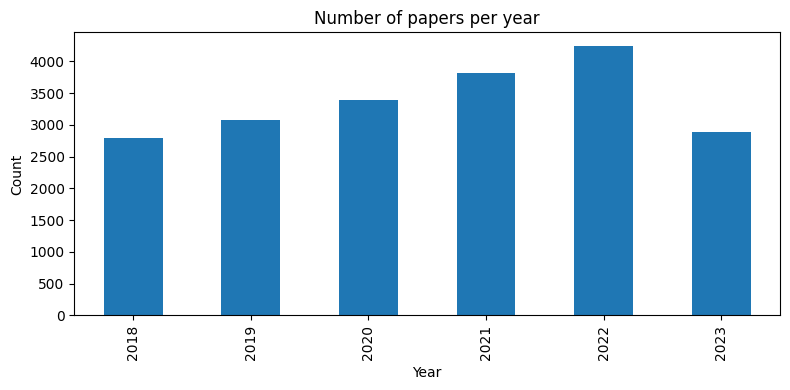

In [ ]:
import matplotlib.pyplot as plt

papers_per_year = df["year"].value_counts().sort_index()
print("=== Papers per year ===")
print(papers_per_year)

plt.figure(figsize=(8,4))
papers_per_year.plot(kind="bar")
plt.title("Number of papers per year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


=== Top 15 journals / sources ===
source_title
Scientific Reports                                                                  438
PLoS ONE                                                                            254
Journal of High Energy Physics                                                      235
Journal of the Medical Association of Thailand                                      201
Engineering Journal                                                                 182
ACM International Conference Proceeding Series                                      144
European Physical Journal C                                                         129
Thai Journal of Veterinary Medicine                                                 119
Journal of Physics: Conference Series                                               111
Physics Letters, Section B: Nuclear, Elementary Particle and High-Energy Physics    104
Journal of Health Research                                               

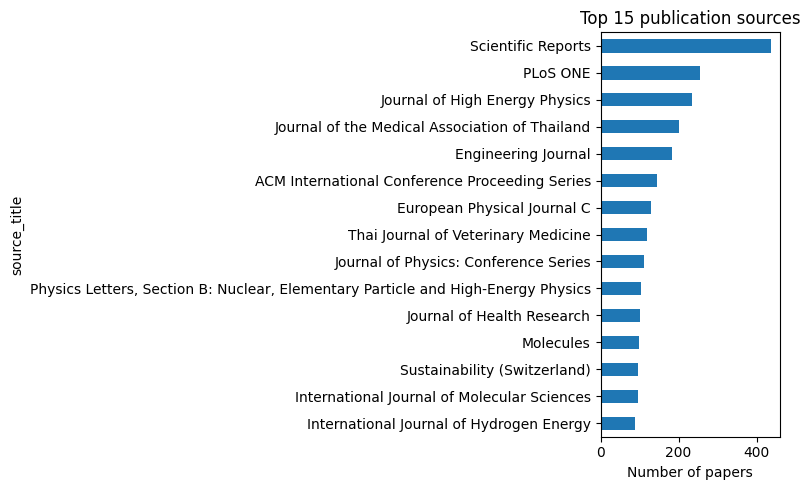

In [ ]:
top_journals = df["source_title"].value_counts().head(15)
print("=== Top 15 journals / sources ===")
print(top_journals)

plt.figure(figsize=(8,5))
top_journals.sort_values().plot(kind="barh")
plt.title("Top 15 publication sources")
plt.xlabel("Number of papers")
plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

kw_counter = Counter()

for kws in df["keywords"].dropna():
    for k in kws.split(";"):
        k = k.strip().lower()
        if k:
            kw_counter[k] += 1

top_kw = kw_counter.most_common(20)
kw_df = pd.DataFrame(top_kw, columns=["keyword", "count"])
print("=== Top 20 keywords ===")
print(kw_df)


=== Top 20 keywords ===
                                   keyword  count
0                                 thailand    749
1                                 covid-19    303
2                             inflammation    200
3   hadron-hadron scattering (experiments)    155
4                         machine learning    147
5                               sars-cov-2    120
6                         oxidative stress    117
7                               depression    116
8                                      hiv    114
9                            deep learning    111
10                                     cms     98
11                             antioxidant     90
12                                children     88
13                           meta-analysis     83
14                            cytotoxicity     82
15                                    asia     81
16                              adsorption     79
17                               apoptosis     79
18                        

In [ ]:
#later use in streamlit
def explore_scopus(df):
    eda = {}
    eda["duplicates_title"] = df.duplicated(subset="title").sum()
    eda["duplicates_doi"] = df.duplicated(subset="doi").sum()
    eda["missing"] = df.isna().sum()
    eda["papers_per_year"] = df["year"].value_counts().sort_index()
    eda["top_journals"] = df["source_title"].value_counts().head(10)
    eda["citation_stats"] = df["citations"].describe()
    return eda

In [ ]:
explore_scopus(df)

{'duplicates_title': np.int64(75),
 'duplicates_doi': np.int64(1197),
 'missing': year               0
 file_id            0
 title              1
 abstract         665
 keywords        3762
 citations          4
 doi             1181
 source_title       0
 dtype: int64,
 'papers_per_year': year
 2018    2792
 2019    3082
 2020    3393
 2021    3815
 2022    4244
 2023    2890
 Name: count, dtype: int64,
 'top_journals': source_title
 Scientific Reports                                                                  438
 PLoS ONE                                                                            254
 Journal of High Energy Physics                                                      235
 Journal of the Medical Association of Thailand                                      201
 Engineering Journal                                                                 182
 ACM International Conference Proceeding Series                                      144
 European Physical Journal 

In [ ]:
df = df.drop_duplicates(subset="doi", keep="first")
df = df.drop_duplicates(subset="title", keep="first")
df = df.reset_index(drop=True)

print("After dropping duplicates:", len(df))


After dropping duplicates: 18984


In [ ]:
output_dir = Path(r"/Users/jidapachutongchai/Downloads/projectDS/data")
output_dir.mkdir(parents=True, exist_ok=True)
df.to_csv(output_dir / "scopus_2018_2023_cleanfinal.csv", index=False)


In [ ]:
df["text"] = (
    df["title"].fillna("") + ". " +
    df["abstract"].fillna("") + ". " +
    df["keywords"].fillna("")
)
df["text"] = df["text"].str.strip()
df["text"].head()


0    Recent developments in bifunctional air electr...
1    The benefit of punishment sensitivity on motor...
2    MAGIC biomarkers predict long-term outcomes fo...
3    Are endocrine disrupting compounds environment...
4    Probabilistic regular grammar inference algori...
Name: text, dtype: object

In [ ]:
from sentence_transformers import SentenceTransformer

path = "/Users/jidapachutongchai/Downloads/projectDS/models"
model = SentenceTransformer("allenai/specter2_base")
model.save(path)


No sentence-transformers model found with name allenai/specter2_base. Creating a new one with mean pooling.


In [ ]:
texts = df["text"].tolist()

embeddings = model.encode(
    texts,
    batch_size=16,
    show_progress_bar=True
)


Batches:   0%|          | 0/1187 [00:00<?, ?it/s]

In [ ]:
import numpy as np
from pathlib import Path

output_dir = Path("/Users/jidapachutongchai/Downloads/projectDS/models")
output_dir.mkdir(parents=True, exist_ok=True)

np.save(output_dir / "specter2_embeddings.npy", embeddings)


In [ ]:
def make_paper_link(row):
    doi = row["doi"]
    
    # If DOI exists → best link
    if isinstance(doi, str) and doi.strip() != "":
        return "https://doi.org/" + doi.strip()
    
    # Otherwise build Scopus link using file_id
    file_id = row["file_id"]
    return f"https://www.scopus.com/record/display.uri?eid=2-s2.0-{file_id}&origin=resultslist"

df["paper_link"] = df.apply(make_paper_link, axis=1)

df[["title", "doi", "paper_link"]].head()


title  \
0  Recent developments in bifunctional air electr...   
1  The benefit of punishment sensitivity on motor...   
2  MAGIC biomarkers predict long-term outcomes fo...   
3  Are endocrine disrupting compounds environment...   
4  Probabilistic regular grammar inference algori...   

                              doi  \
0  10.1016/j.ijhydene.2018.09.152   
1              10.1111/jopy.12318   
2    10.1182/blood-2018-01-822957   
3     10.1016/j.yhbeh.2017.10.003   
4                            None   

                                          paper_link  
0     https://doi.org/10.1016/j.ijhydene.2018.09.152  
1                 https://doi.org/10.1111/jopy.12318  
2       https://doi.org/10.1182/blood-2018-01-822957  
3        https://doi.org/10.1016/j.yhbeh.2017.10.003  
4  https://www.scopus.com/record/display.uri?eid=...

In [ ]:
output_dir = Path(r"/Users/jidapachutongchai/Downloads/projectDS/data")
output_dir.mkdir(parents=True, exist_ok=True)
df.to_csv(output_dir / "scopus_2018_2023_cleanVer2.csv", index=False)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML
import re

def scholar_search(query, k=10, min_match_words=1):
    # 1) Split query into words
    words = [w.lower() for w in re.findall(r"\w+", query) if len(w) > 2]
    if not words:
        return HTML("<b>No valid query words.</b>")
    
    # 2) Make sure we have lowercased text
    if "text_lower" not in df.columns:
        df["text_lower"] = df["text"].fillna("").str.lower().str.strip()
    
    texts = df["text_lower"].fillna("")
    
    # 3) Filter: keep rows that contain at least min_match_words from query
    mask = []
    for t in texts:
        count = 0
        for w in words:
            if w in t:
                count += 1
        mask.append(count >= min_match_words)
    
    mask = np.array(mask)
    candidate_idx = np.where(mask)[0]
    
    if len(candidate_idx) == 0:
        return HTML("<b>No papers contain your query words.</b>")
    
    # 4) Rank candidates with SPECTER2
    q_emb = model.encode([query])
    sims_all = cosine_similarity(q_emb, embeddings)[0]
    sims = sims_all[candidate_idx]
    
    top_local = sims.argsort()[::-1][:k]
    top_idx = candidate_idx[top_local]
    
    result = df.iloc[top_idx][[
        "year", "title", "source_title", "citations", "keywords", "paper_link"
    ]].copy()
    result["similarity"] = sims[top_local]
    
    # 5) Clickable links
    def make_clickable(url):
        if isinstance(url, str) and url.strip():
            return f'<a href="{url}" target="_blank">Open</a>'
        return ""
    
    result["paper_link"] = result["paper_link"].apply(make_clickable)
    
    return HTML(result.to_html(escape=False))

In [ ]:
scholar_search("pig", k=10, min_match_words=1)

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
import umap
from sklearn.preprocessing import normalize
import joblib
pathData = Path(r"/Users/jidapachutongchai/Downloads/projectDS/data")
pathEmbed = Path("/Users/jidapachutongchai/Downloads/projectDS/models")
n_cluster = 20
metadata = pd.read_csv(pathData/"scopus_2018_2023_cleanfinal.csv")
embeddings = np.load(pathEmbed/"specter2_embeddings.npy")
X_norm = normalize(embeddings)
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=10,  # 10–20 is good
    metric="cosine",
    random_state = 0
)
X_reduced = umap_model.fit_transform(X_norm)
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)
kmeans = KMeans(n_clusters = 20, random_state= 0 )
param_grid = {"n_clusters": [5, 7,8], "random_state": [0]}
grid = GridSearchCV(estimator = kmeans, param_grid= param_grid,scoring=silhouette_scorer, n_jobs=1)
grid.fit(X_reduced)
best_model = grid.best_estimator_
print(best_model)
best_model.fit(X_reduced)

joblib.dump(
    umap_model,
    "/Users/jidapachutongchai/Downloads/projectDS/models/umap_model.pkl"
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



KMeans(n_clusters=5, random_state=0)


['/Users/jidapachutongchai/Downloads/projectDS/models/umap_model.pkl']

In [ ]:
print(umap.__version__)

0.5.9.post2


In [ ]:
import joblib
joblib.dump(X_norm, "/Users/jidapachutongchai/Downloads/projectDS/models/X_norm")

['/Users/jidapachutongchai/Downloads/projectDS/models/X_norm']

In [ ]:
print(grid.best_params_)
print(best_model)

{'n_clusters': 5, 'random_state': 0}
KMeans(n_clusters=5, random_state=0)


In [ ]:
label = best_model.predict(X_reduced)
print(label)

[2 4 1 ... 2 1 1]


In [ ]:
print("Best silhouette:", grid.best_score_)

Best silhouette: 0.42184126377105713


In [ ]:
print(len(np.unique(label)))

5


In [ ]:
import joblib
from pathlib import Path

output_dir = Path("/Users/jidapachutongchai/Downloads/projectDS/models")
output_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, output_dir / "kmeans_model.pkl")
joblib.dump(label, output_dir / "label.pkl")


['/Users/jidapachutongchai/Downloads/projectDS/models/label.pkl']

In [ ]:
metadata['cluster'] = label
metadata[['title','cluster']]
metadata.loc[metadata['cluster'] == 4]

year    file_id                                              title  \
1      2018  201801350  The benefit of punishment sensitivity on motor...   
17     2018  201800847  The effects of an educational program on knowl...   
24     2018  201802526                                       Introduction   
37     2018  201802519  The critical factors of research and innovatio...   
44     2018  201800623  Rational use of paracetamol among out-patients...   
...     ...        ...                                                ...   
18941  2023  202301464  Cross-cultural adaptation and psychometric pro...   
18952  2023  202300322  Linear tourism, multiculturalism, creative dis...   
18954  2023  202301694  What Influences Older Urban Poor’s Attitude to...   
18955  2023  202300574  Strategic flexibility: a systematic review and...   
18956  2023  202302223  COVID-19 infodemic on Facebook: a social netwo...   

                                                abstract  \
1      Objective: Humans are often required to perfor...   
17     Purpose – University students who have low kno...   
24     India and Southeast Asian countries are strivi...   
37     A university, which is the main form of higher...   
44     Objective: Paracetamol or acetaminophen is a w...   
...                                                  ...   
18941  Objective The aim of this study was to cross-c...   
18952  The paper examines the relationship between to...   
18954  There is an increasing number of older adults ...   
18955  Purpose: Strategic flexibility (SF) has become...   
18956  Many studies on the COVID-19 infodemic cover a...   

                                                keywords  citations  \
1      anxiety; defensive distance; performance; rein...        2.0   
17     Condom and emergency contraceptive pills use; ...        8.0   
24                                                   NaN        0.0   
37     Critical factors; Innovation creation; Public ...       33.0   
44     Acetaminophen; Health knowledge, attitudes, pr...        5.0   
...                                                  ...        ...   
18941                                                NaN        0.0   
18952  Bangkok; Creative district; Linear tourism; Mu...        0.0   
18954  determinants; development; internet; job searc...        0.0   
18955  Organizational flexibility; Strategic change; ...        0.0   
18956  COVID-19; disinformation; Facebook; infodemic;...        0.0   

                                 doi  \
1                 10.1111/jopy.12318   
17           10.1108/JHR-05-2018-033   
24             10.4324/9781351013598   
37         10.1504/IJTGM.2018.092486   
44         10.1186/s13104-018-3764-0   
...                              ...   
18941   10.1371/journal.pone.0282880   
18952   10.1016/j.annals.2023.103626   
18954     10.3390/smartcities6010028   
18955      10.1108/JSMA-08-2022-0134   
18956  10.1080/15358593.2022.2142067   

                                            source_title  cluster  
1                                 Journal of Personality        4  
17                            Journal of Health Research        4  
24     Celebrating the Third Decade and Beyond: New C...        4  
37     International Journal of Trade and Global Markets        4  
44                                    BMC Research Notes        4  
...                                                  ...      ...  
18941                                           PLoS ONE        4  
18952                         Annals of Tourism Research        4  
18954                                       Smart Cities        4  
18955                 Journal of Strategy and Management        4  
18956                            Review of Communication        4  

[2470 rows x 9 columns]

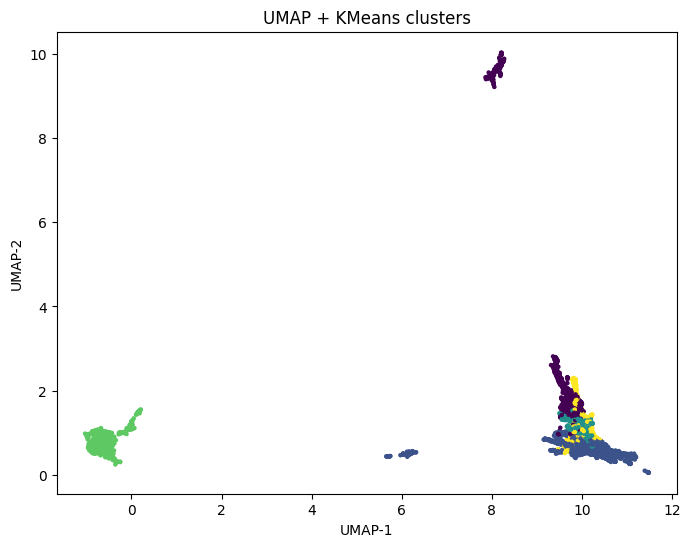

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=label,
    s=5
)
plt.title("UMAP + KMeans clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [ ]:
cluster_summary = (
    metadata
    .groupby("cluster")
    .agg(
        cluster_size=("cluster", "size"),
        min_year=("year", "min"),
        max_year=("year", "max"),
        mean_year=("year", "mean")
    )
    .sort_index()
)

print(cluster_summary)

         cluster_size  min_year  max_year    mean_year
cluster                                               
0                2875      2018      2023  2020.528696
1                8074      2018      2023  2020.736190
2                4976      2018      2023  2020.607315
3                 589      2018      2023  2019.823430
4                2470      2018      2023  2020.769231


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



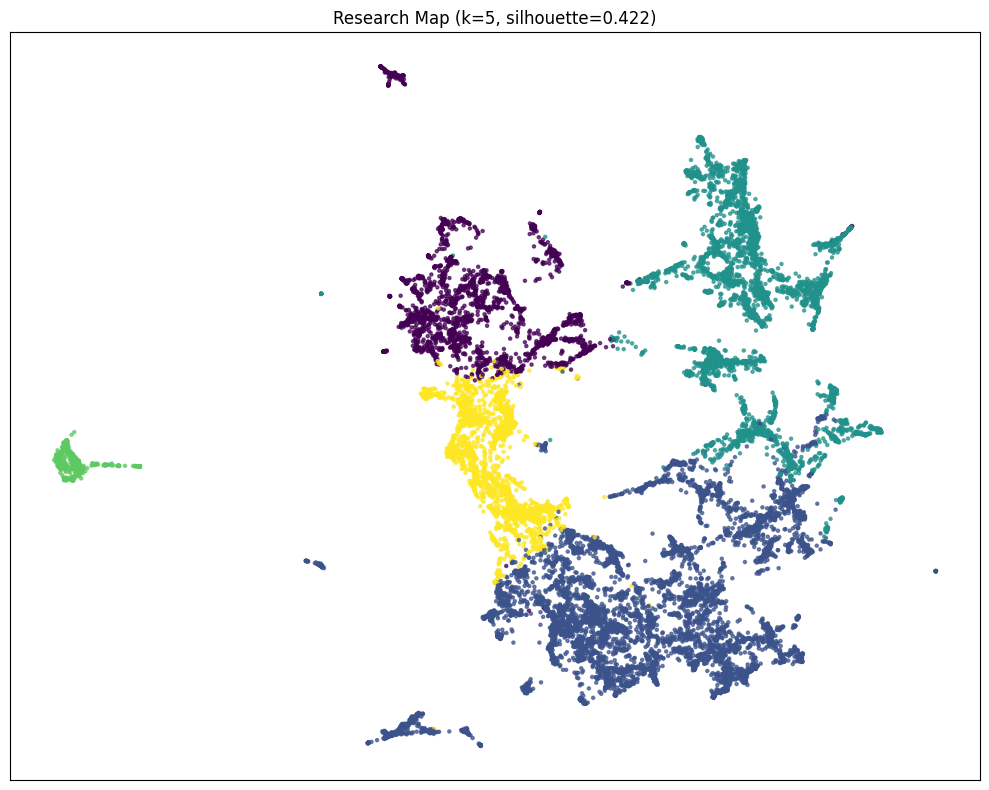

['/Users/jidapachutongchai/Downloads/projectDS/models/umap_vis.pkl']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import joblib

output_dir = Path("/Users/jidapachutongchai/Downloads/projectDS/models")
output_dir.mkdir(parents=True, exist_ok=True)

# 1) ทำ UMAP 2 มิติสำหรับ visualization โดยเฉพาะ
umap_vis = umap.UMAP(
    n_neighbors=15,
    min_dist=0.0,          # ทำให้ก้อนแน่นขึ้น ดูเป็น cluster ชัดขึ้น
    n_components=2,
    metric="cosine",
    random_state=42, 
    force_approximation_algorithm=True
)
X_vis = umap_vis.fit_transform(X_norm)   # ใช้ X_norm เดิม
joblib.dump(X_vis, output_dir / "X_vis.pkl")
# 2) ใช้ labels จาก KMeans เดิม
labels = best_model.labels_
n_clusters = len(np.unique(labels))

# 3) plot ให้ดูสะอาดขึ้น
plt.figure(figsize=(10, 8))
plt.scatter(
    X_vis[:, 0],
    X_vis[:, 1],
    c=labels,
    s=5,
    alpha=0.7
)
plt.title(f"Research Map (k={n_clusters}, silhouette={grid.best_score_:.3f})")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

joblib.dump(umap_vis, output_dir / "umap_vis.pkl")

In [ ]:
import joblib
from pathlib import Path

output_dir = Path("/Users/jidapachutongchai/Downloads/projectDS/models")
output_dir.mkdir(parents=True, exist_ok=True)

umap_embedding = umap_model.embedding_

joblib.dump(umap_embedding, output_dir / "umap_model2.pkl")

['/Users/jidapachutongchai/Downloads/projectDS/models/umap_model2.pkl']

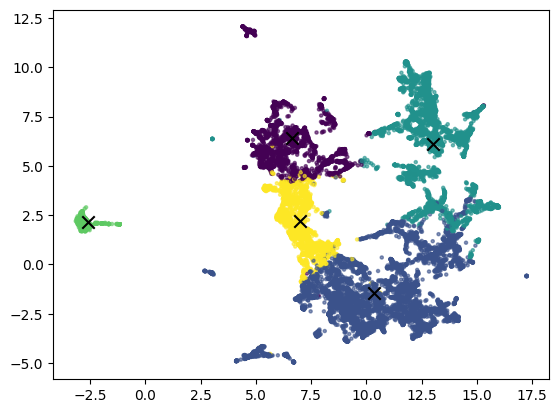

In [ ]:
centers = np.vstack([
    X_vis[labels == k].mean(axis=0)
    for k in np.unique(labels)
])

plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, s=5, alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=80, marker="x")
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter(
    x=X_vis[:, 0],
    y=X_vis[:, 1],
    color=labels,
    hover_data={"title": metadata["title"], "year": metadata["year"]}
)
fig.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
def describe_clusters(metadata, text_col="title", cluster_col="cluster", n_top_terms=10):
    cluster_texts = (
        metadata
        .groupby(cluster_col)[text_col]
        .apply(lambda x: " ".join(x.dropna().astype(str)))
    )
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 2), max_df= 0.7, min_df = 2)
    boring_terms = {
        "study", "studies", "data", "analysis", "approach", "method",
        "methods", "model", "models", "based", "using", "use",
        "patients", "treatment", "treatments", "clinical", "group",
        "effect", "effects", "research", "paper", "result", "results", "older", "questionnaire", "participants"
    }
    X_tfidf = vectorizer.fit_transform(cluster_texts.values)
    terms = np.array(vectorizer.get_feature_names_out())
    cluster_descriptions = {}
    for cid, row in zip(cluster_texts.index, X_tfidf):
        row = row.toarray().ravel()
        idx_sorted = row.argsort()[::-1]

        top_terms = []
        for i in idx_sorted:
            term = terms[i]
            if term in boring_terms:
                continue
            top_terms.append(term)
            if len(top_terms) >= n_top_terms:
                break

        cluster_descriptions[cid] = top_terms

        print(f"\n=== Cluster {cid} ===")
        print(", ".join(top_terms))

    return cluster_descriptions

In [ ]:
metadata["text_all"] = metadata["title"].fillna("") + " " + metadata["abstract"].fillna("")
cluster_desc = describe_clusters(metadata, text_col="text_all")
cluster_desc


=== Cluster 0 ===
groundwater, fault, cnn, rainfall, finite element, iot, seismic, tsunami, undrained, renewable energy

=== Cluster 1 ===
immune, genes, il, inflammatory, mice, antioxidant, isolates, pcr, antibody, receptor

=== Cluster 2 ===
adsorption, catalytic, oxide, nanoparticles, ni, tio2, electrochemical, graphene, composites, biomass

=== Cluster 3 ===
tev, proton proton, boson, 13 tev, proton collisions, quark, luminosity, gev, higgs, standard model

=== Cluster 4 ===
intention, firms, cognitive, attitude, nursing, interviews, teachers, gender, corporate, financial


{0: ['groundwater',
  'fault',
  'cnn',
  'rainfall',
  'finite element',
  'iot',
  'seismic',
  'tsunami',
  'undrained',
  'renewable energy'],
 1: ['immune',
  'genes',
  'il',
  'inflammatory',
  'mice',
  'antioxidant',
  'isolates',
  'pcr',
  'antibody',
  'receptor'],
 2: ['adsorption',
  'catalytic',
  'oxide',
  'nanoparticles',
  'ni',
  'tio2',
  'electrochemical',
  'graphene',
  'composites',
  'biomass'],
 3: ['tev',
  'proton proton',
  'boson',
  '13 tev',
  'proton collisions',
  'quark',
  'luminosity',
  'gev',
  'higgs',
  'standard model'],
 4: ['intention',
  'firms',
  'cognitive',
  'attitude',
  'nursing',
  'interviews',
  'teachers',
  'gender',
  'corporate',
  'financial']}

In [ ]:
cluster_labels = {
    0: "Geoscience, Natural Hazards & Environmental Engineering",
    1: "Immunology & Molecular Biomedical Research",
    2: "Catalysis, Nanomaterials & Energy Materials",
    3: "High-Energy Particle Physics (CERN / Higgs / TeV)",
    4: "Social Sciences, Education & Organizational Behavior",
}
metadata['clusterLabel'] = metadata['cluster'].map(cluster_labels)
out_stat = Path("/Users/jidapachutongchai/Downloads/projectDS/stat")
out_stat.mkdir(parents=True, exist_ok=True)
joblib.dump(cluster_labels, out_stat / "cluster_labels.pkl")
print(metadata[['cluster', 'clusterLabel']])

       cluster                                       clusterLabel
0            2        Catalysis, Nanomaterials & Energy Materials
1            4  Social Sciences, Education & Organizational Be...
2            1         Immunology & Molecular Biomedical Research
3            1         Immunology & Molecular Biomedical Research
4            0  Geoscience, Natural Hazards & Environmental En...
...        ...                                                ...
18979        1         Immunology & Molecular Biomedical Research
18980        1         Immunology & Molecular Biomedical Research
18981        2        Catalysis, Nanomaterials & Energy Materials
18982        1         Immunology & Molecular Biomedical Research
18983        1         Immunology & Molecular Biomedical Research

[18984 rows x 2 columns]


In [ ]:
from sentence_transformers import SentenceTransformer
pathModel = "/Users/jidapachutongchai/Downloads/projectDS/models"
encoder = SentenceTransformer(pathModel)
print(encoder.encode(["hello"]).shape) #Dimension checked


(1, 768)


In [ ]:
import numpy as np
labels = best_model.labels_
cluster_stats = {}
for cid in sorted(np.unique(labels)):
    pts = X_reduced[labels == cid]            # จุดในคลัสเตอร์นี้ (10D UMAP space)
    centroid = best_model.cluster_centers_[cid]

    dists = np.linalg.norm(pts - centroid, axis=1)
    mu = dists.mean()
    sigma = dists.std() + 1e-8    # กันหาร 0

    cluster_stats[cid] = {
        "centroid": centroid,
        "dists": dists,
        "mean_dist": mu,
        "std_dist": sigma,
    }
joblib.dump(cluster_stats, "/Users/jidapachutongchai/Downloads/projectDS/stat/cluster_stats.pkl")


['/Users/jidapachutongchai/Downloads/projectDS/stat/cluster_stats.pkl']

In [ ]:
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer
def position_idea(idea_text: str,encoder_model,umap_model,kmeans_model,cluster_stats, labels):
    ideaCode = encoder.encode([idea_text])
    ideaCodeNorm = normalize(ideaCode)
    ideaUmap = umap_model.transform(ideaCodeNorm)
    clusterID = int(kmeans_model.predict(ideaUmap)[0])
    stats = cluster_stats[clusterID]
    centroid = stats["centroid"]
    dists_cluster = stats["dists"]
    mean_dist = stats["mean_dist"]
    std_dist = stats["std_dist"]
    dist = float(np.linalg.norm(ideaUmap[0] - centroid))
    novelty_z = (dist - mean_dist) / std_dist
    percentile = float((dists_cluster < dist).mean())
    clusterLabel = ""
    if clusterID == 0:
        clusterLabel = cluster_labels[0]
    elif clusterID == 1:
        clusterLabel = cluster_labels[1]
    elif clusterID == 2:
        clusterLabel = cluster_labels[2]
    elif clusterID == 3:
        clusterLabel = cluster_labels[3]
    elif clusterID == 4:
        clusterLabel = cluster_labels[4]
    
    return {
        "Cluster id": clusterID,
        "Cluster Label": clusterLabel,
        "Idea_Umap": ideaUmap[0],
        "distance_to_centroid": dist,
        "novelty_z": float(novelty_z),
        "novelty_percentile": percentile,
    }


In [ ]:
idea = """
antimicrobial activity E. coli
"""

pathModel = "/Users/jidapachutongchai/Downloads/projectDS/models"

from sentence_transformers import SentenceTransformer
import joblib

# load encoder from local folder
encoder = SentenceTransformer(pathModel)

# load models
kmeans_model = joblib.load("/Users/jidapachutongchai/Downloads/projectDS/models/kmeans_model.pkl")
umap_model  = joblib.load("/Users/jidapachutongchai/Downloads/projectDS/models/umap_model.pkl")  # 10-D UMAP

# compute position
result = position_idea(
    idea_text = idea,
    encoder_model = encoder,
    umap_model = umap_model,
    kmeans_model = kmeans_model,
    cluster_stats = cluster_stats,
    labels = labels,
)

print("Cluster ID:    ", result["Cluster id"])
print("Cluster label: ", result["Cluster Label"])
print("Distance:      ", round(result["distance_to_centroid"], 4))
print("Novelty z:     ", round(result["novelty_z"], 2))
print("Novelty pct:   ", f"{result['novelty_percentile']*100:.1f}%")


Cluster ID:     1
Cluster label:  Immunology & Molecular Biomedical Research
Distance:       2.1675
Novelty z:      -0.04
Novelty pct:    51.7%


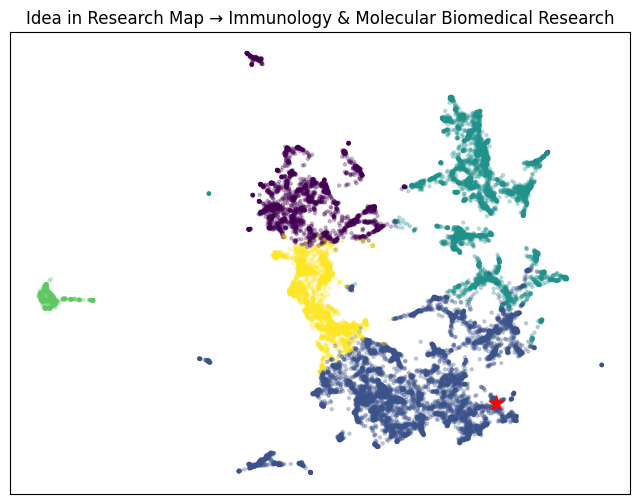

In [ ]:
idea_vis = umap_vis.transform(normalize(encoder.encode([idea])))

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:,0], X_vis[:,1], c=labels, s=5, alpha=0.25)
plt.scatter(idea_vis[0,0], idea_vis[0,1], c="red", s=120, marker="*")
plt.xticks([]); plt.yticks([])
plt.title(f"Idea in Research Map → {result['Cluster Label']}")
plt.show()